# Stanford UFLDL
## Machine Learning Exercise 4 - Neural Networks
<a href="http://ufldl.stanford.edu/wiki/index.php/UFLDL_Tutorial">Wiki</a>
<a href="http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/">Exercise 4</a>

### Feed-forward neural network with backpropagation
For this exercise we'll again tackle the hand-written digits data set, this time using a feed-forward neural network with backpropagation. We'll implement un-regularized and regularized versions of the neural network cost function and gradient computation via the backpropagation algorithm. We'll also implement random weight initialization and a method to use the network to make predictions.

Since the data set is the same one we used in exercise 3, we'll re-use the code to load the data.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

data = loadmat('data/ex3data1.mat')
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

Since we're going to need these later (and will use them often), let's create some useful variables up-front.

In [2]:
X = data['X']
y = data['y']

X.shape, y.shape

((5000, 400), (5000, 1))

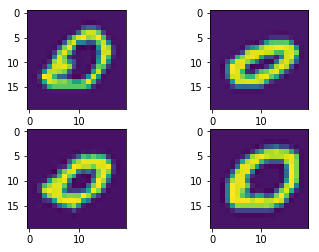

In [26]:
for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.imshow(np.reshape(X[i], (20,20)))    

We're also going to need to one-hot encode our y labels.  One-hot encoding turns a class label n (out of k classes) into a vector of length k where index n is "hot" (1) while the rest are zero.  Scikit-learn has a built in utility we can use for this.

In [27]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [28]:
y[0], y_onehot[0,:]

(array([10], dtype=uint8),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]))

The neural network we're going to build for this exercise has an input layer matching the size of our instance data (400 + the bias unit), a hidden layer with 25 units (26 with the bias unit), and an output layer with 10 units corresponding to our one-hot encoding for the class labels.  For additional details and an image of the network architecture, please refer to the PDF in the "exercises" folder.

The first piece we need to implement is a cost function to evaluate the loss for a given set of network parameters.  The source mathematical function is in the exercise text (and looks pretty intimidating).  Here are the functions required to compute the cost.

In [29]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [30]:
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 * theta2.T
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

In [31]:
def cost(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    return J

We've used the sigmoid function before so that's not new.  The forward-propagate function computes the hypothesis for each training instance given the current parameters.  It's output shape should match the same of our one-hot encoding for y.  We can test this real quick to convince ourselves that it's working as expected (the intermediate steps are also returned as these will be useful later).

In [32]:
# initial setup
input_size = 400
hidden_size = 25
num_labels = 10
learning_rate = 1

# randomly initialize a parameter array of the size of the full network's parameters
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25

m = X.shape[0]
X = np.matrix(X)
y = np.matrix(y)

# unravel the parameter array into parameter matrices for each layer
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

theta1.shape, theta2.shape

((25, 401), (10, 26))

In [33]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

The cost function, after computing the hypothesis matrix h, applies the cost equation to compute the total error between y and h.

In [34]:
cost(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)

7.083108708013782

Our next step is to add regularization to the cost function.  If you're following along in the exercise text and thought the last equation looked ugly, this one looks REALLY ugly.  It's actually not as complicated as it looks though - in fact, the regularization term is simply an addition to the cost we already computed.  Here's the revised cost function.

In [35]:
def cost(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    return J

In [36]:
cost(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)

7.0883964650856628

Next up is the backpropagation algorithm.  Backpropagation computes the parameter updates that will reduce the error of the network on the training data.  The first thing we need is a function that computes the gradient of the sigmoid function we created earlier.

In [37]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

Now we're ready to implement backpropagation to compute the gradients.  Since the computations required for backpropagation are a superset of those required in the cost function, we're actually going to extend the cost function to also perform backpropagation and return both the cost and the gradients.

In [38]:
def backprop(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

The hardest part of the backprop computation (other than understanding WHY we're doing all these calculations) is getting the matrix dimensions right.  By the way, if you find it confusing when to use A * B vs. np.multiply(A, B), you're not alone.  Basically the former is a matrix multiplication and the latter is an element-wise multiplication (unless A or B is a scalar value, in which case it doesn't matter).  I wish there was a more concise syntax for this (maybe there is and I'm just not aware of it).

Anyway, let's test it out to make sure the function returns what we're expecting it to.

In [39]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)
J, grad.shape

(7.0883964650856628, (10285,))

We still have one more modification to make to the backprop function - adding regularization to the gradient calculations.  The final regularized version is below.

In [40]:
def backprop(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # add the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

In [41]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)
J, grad.shape

(7.0883964650856628, (10285,))

We're finally ready to train our network and use it to make predictions.  This is roughly similar to the previous exercise with multi-class logistic regression.

In [42]:
from scipy.optimize import minimize

# minimize the objective function
fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate), 
                method='TNC', jac=True, options={'maxiter': 250})
fmin

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in multiply


     fun: 0.37312330652840253
     jac: array([  8.61267807e-04,   8.37895581e-06,  -6.29330433e-06, ...,
        -3.74005032e-04,  -7.09145244e-05,  -2.50665002e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 17
  status: 3
 success: False
       x: array([-0.44734352,  0.04189478, -0.03146652, ..., -1.19987218,
       -2.46024828,  0.59101178])

We put a bound on the number of iterations since the objective function is not likely to completely converge.  Our total cost has dropped below 0.5 though so that's a good indicator that the algorithm is working.  Let's use the parameters it found and forward-propagate them through the network to get some predictions.

In [43]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred

array([[10],
       [10],
       [10],
       ..., 
       [ 9],
       [ 9],
       [ 9]])

Finally we can compute the accuracy to see how well our trained network is doing.

In [44]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print 'accuracy = {0}%'.format(accuracy * 100)

accuracy = 98.4%


And we're done!  We've successfully implemented a rudimentary feed-forward neural network with backpropagation and used it to classify images of handwritten digits.  In the next exercise we'll look at another power supervised learning algorithm, support vector machines.